# Linear Regression Example: Bike Share Data

In this example, we look at the bike share data, and fit some linear models, using one of the datasets from PiML.

Note that these examples illustrate the mechanics of fitting such models, and do not sufficiently capture all the important features present in the data.

## Setup

Here we import the required modules and functions and mount the google drive (if required).

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import SplineTransformer

**Mounting the Google Drive**

This assumes you have previously downloaded the PiML GitHub repository, and are running this notebook from its location in that repository.  Otherwise, you may need to adjust the path to the data as needed.

If you are working in a different environment, this step will not be necessary.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cd 'gdrive/My Drive/piml'

/content/gdrive/My Drive/piml


In [ ]:
%ls PiML-Toolbox/datasets

BikeSharing.csv        FairnessCreditSimu.csv  SolasHMDA.csv
CaliforniaHousing.csv  SimuCredit.csv          TaiwanCredit.csv


In [ ]:
## Read and Prepare Data

In [ ]:
## Read the data
data = pd.read_csv("PiML-Toolbox/datasets/BikeSharing.csv")

In [ ]:
## Look at a sumary of the data
data.describe()

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
count,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,2.501640,0.502561,6.537775,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,189.463088
std,1.106918,0.500008,3.438776,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,181.387599
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,4.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,40.000000
50%,3.000000,1.000000,7.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,142.000000
75%,3.000000,1.000000,10.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,281.000000
max,4.000000,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,977.000000


In [ ]:
data.columns

Index(['season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday',
       'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'cnt'],
      dtype='object')

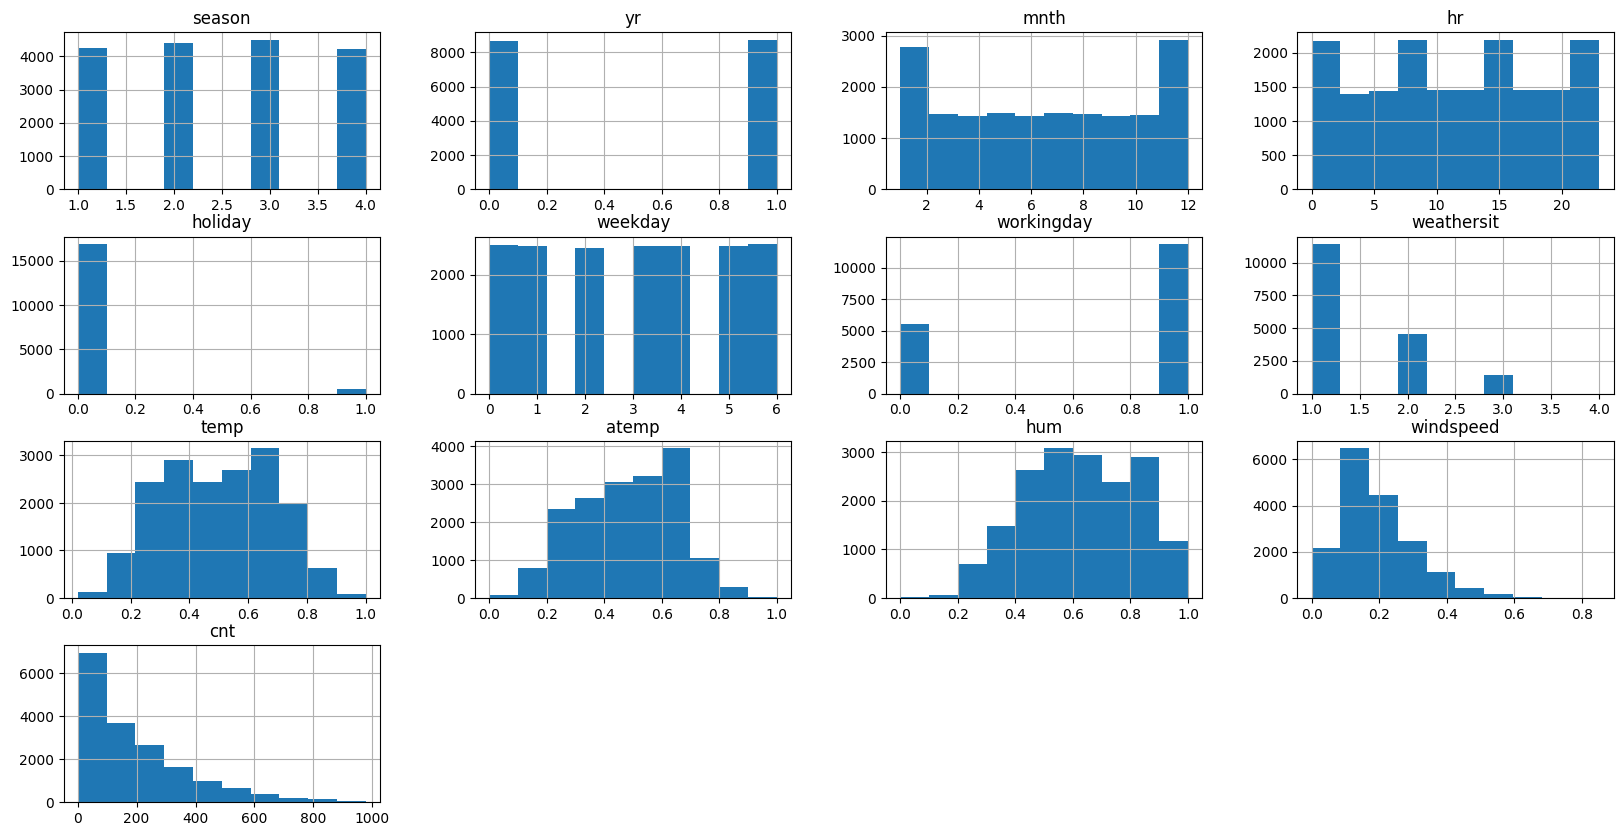

In [ ]:
## Look at the univariate data distributions
_ = data.hist(figsize=(20, 10))

<Axes: >

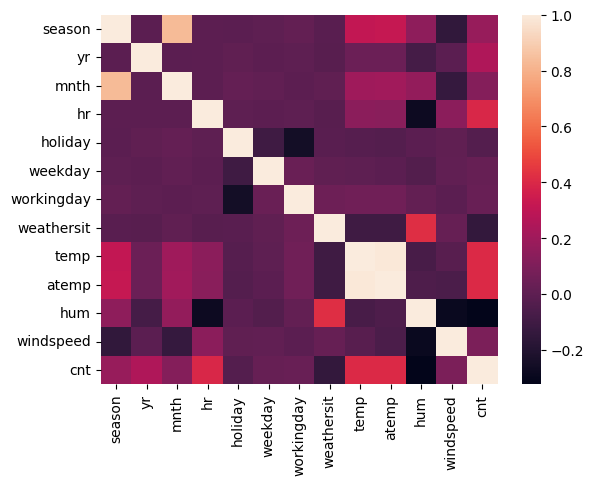

In [ ]:
## Examine the correlation structure between variables
sns.heatmap(data.corr())

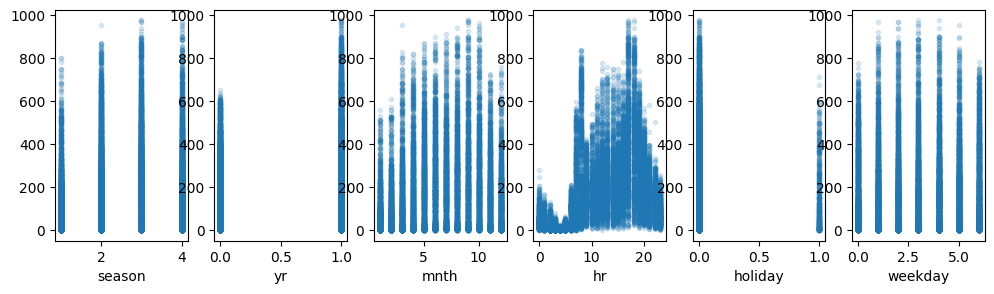

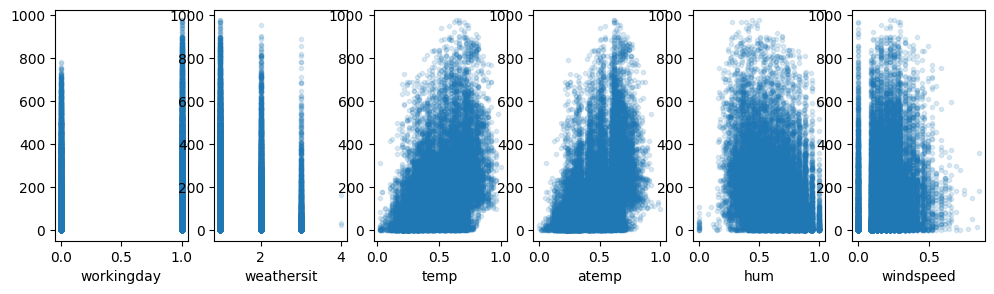

In [ ]:
## Here we plot the response ('cnt') against each of the potential predictors
## as a scatterplot to examine the univariate relationships

fig, ax = plt.subplots(1, 6, squeeze=True, figsize=(12, 3))
for i, v in enumerate(data.columns[:6]):
  ax[i].plot(data[v], data['cnt'], '.', alpha=0.15)
  ax[i].set_xlabel(v)
fig.show()

fig, ax = plt.subplots(1, 6, squeeze=True, figsize=(12, 3))
for i, v in enumerate(data.columns[6:12]):
  ax[i].plot(data[v], data['cnt'], '.', alpha=0.15)
  ax[i].set_xlabel(v)
fig.show()

## Transformations
Prepare the data by carrying out some transformations.

In [ ]:
## Encode the Categorical Variables season and weathersit
tdata = pd.get_dummies(data, columns=['season', 'weathersit'], drop_first=True)
tdata.columns

Index(['yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'temp', 'atemp',
       'hum', 'windspeed', 'cnt', 'season_2', 'season_3', 'season_4',
       'weathersit_2', 'weathersit_3', 'weathersit_4'],
      dtype='object')

In [ ]:
predictors = ['hr', 'workingday', 'atemp', 'hum', 'windspeed', 'season_2', 'season_3', 'season_4',
       'weathersit_2', 'weathersit_3', 'weathersit_4']
response = 'cnt'
X= tdata[predictors]
## Note that we are taking a log-transform of the response
Y= np.log(tdata[response])

In [ ]:
## Prep the data-- Train/Test Split
train_x,  test_x, train_y, test_y  = train_test_split(X, Y, test_size=0.2, random_state=0)

In [ ]:
## Check the data again
train_x.describe()

,hr,workingday,atemp,hum,windspeed,season_2,season_3,season_4,weathersit_2,weathersit_3,weathersit_4
count,13903.000000,13903.000000,13903.000000,13903.000000,13903.000000,13903.000000,13903.000000,13903.000000,13903.000000,13903.000000,13903.000000
mean,11.532547,0.684744,0.476793,0.626279,0.190419,0.254765,0.257786,0.241531,0.258362,0.080774,0.000216
std,6.920199,0.464634,0.171658,0.192582,0.122419,0.435745,0.437431,0.428027,0.437749,0.272497,0.014688
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.000000,0.000000,0.333300,0.470000,0.104500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,12.000000,1.000000,0.484800,0.620000,0.194000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,18.000000,1.000000,0.621200,0.780000,0.253700,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000
max,23.000000,1.000000,1.000000,1.000000,0.850700,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Fit Linear Regression Models

We try to show both scikit-learn and statsmodels approaches.

### Fitting scikit-learn estimator

Note that it is simply fitting the regression, not carrying out important diagnostics.

In [ ]:
sklm = LinearRegression()
sklm.fit(train_x, train_y)

LinearRegression()

In [ ]:
## Retrieve the coefficients
sklm.coef_

array([ 1.00024142e-01, -4.02991497e-02,  2.88909910e+00, -1.48158746e+00,
        3.83581429e-01,  1.53110521e-01,  4.44023789e-04,  4.98592484e-01,
        1.76145433e-01, -1.89597132e-01,  7.92511399e-01])

In [ ]:
## Nicer way to look at the coeffients.
pd.Series(sklm.coef_, index=predictors)

hr              0.100024
workingday     -0.040299
atemp           2.889099
hum            -1.481587
windspeed       0.383581
season_2        0.153111
season_3        0.000444
season_4        0.498592
weathersit_2    0.176145
weathersit_3   -0.189597
weathersit_4    0.792511
dtype: float64

In [ ]:
## Retreive Intercept Term:
sklm.intercept_

2.697545267813866

In [ ]:
## Examine the Performance -- Get predicted values
train_yhat = sklm.predict(train_x)
test_yhat = sklm.predict(test_x)

In [ ]:
## Calculate Metrics
print('MSE for test:', round(mean_squared_error(test_y, test_yhat), 4))
print('MSE for training:', round(mean_squared_error(train_y, train_yhat),4))
print('MAE for test:', round(mean_absolute_error(test_y, test_yhat), 4))
print('MAE for training:', round(mean_absolute_error(train_y, train_yhat),4))
print('r2 for test:', round(r2_score(test_y, test_yhat), 4))
print('r2 for training:', round(r2_score(train_y, train_yhat),4))

MSE for test: 1.1635
MSE for training: 1.1707
MAE for test: 0.839
MAE for training: 0.8465
r2 for test: 0.4792
r2 for training: 0.4684


### Fitting the Linear Regression with statsmodels

**Note:** The inference below requires additional analysis to verify the linear model assumptions (not shown!!!)

In [ ]:
## Now try the statsmodels approach:
sm_train_x = sm.add_constant(train_x)
sm_test_x = sm.add_constant(test_x)
smlm = sm.OLS(train_y, sm_train_x, hasconst=True)
results = smlm.fit()

In [ ]:
results.params

const           2.697545
hr              0.100024
workingday     -0.040299
atemp           2.889099
hum            -1.481587
windspeed       0.383581
season_2        0.153111
season_3        0.000444
season_4        0.498592
weathersit_2    0.176145
weathersit_3   -0.189597
weathersit_4    0.792511
dtype: float64

In [ ]:
## Look at the Statistical Summary
## Remember: Need to evaluate modeling assumptions if you're going to use these!
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.468
Model:                            OLS   Adj. R-squared:                  0.468
Method:                 Least Squares   F-statistic:                     1113.
Date:                Mon, 11 Sep 2023   Prob (F-statistic):               0.00
Time:                        16:06:02   Log-Likelihood:                -20823.
No. Observations:               13903   AIC:                         4.167e+04
Df Residuals:                   13891   BIC:                         4.176e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            2.6975      0.058     46.719   

## Nonlinear Feature Construction
Now, we try to create some non-linear transformations of some of the numerical predictors to see of we can better capture the (non-linear) relationship between some of the predictors (hour, atemp) with the response.

We use some flexible splines as an example, the main idea is to provide a nonlinear tranformation.

Reference: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.SplineTransformer.html

In [ ]:
## Create Spline Transformers for
nk = 5
tf_hr = SplineTransformer(degree=3, n_knots=nk)
tf_at = SplineTransformer(degree=3, n_knots=nk)

## Set ups spline terms for the hour
tf_hr.fit(train_x['hr'].values.reshape(-1,1))
hr_sp_train = pd.DataFrame(tf_hr.transform(train_x['hr'].values.reshape(-1,1)),
                     columns=['hr_sp'+str(i) for i in range(nk+2)])
hr_sp_test = pd.DataFrame(tf_hr.transform(test_x['hr'].values.reshape(-1,1)),
                     columns=['hr_sp'+str(i) for i in range(nk+2)])

## Set up spline terms for atemp
tf_at.fit(train_x['atemp'].values.reshape(-1,1))
at_sp_train = pd.DataFrame(tf_at.transform(train_x['atemp'].values.reshape(-1,1)),
                     columns=['at_sp'+str(i) for i in range(nk+2)])
at_sp_test = pd.DataFrame(tf_at.transform(test_x['atemp'].values.reshape(-1,1)),
                     columns=['at_sp'+str(i) for i in range(nk+2)])


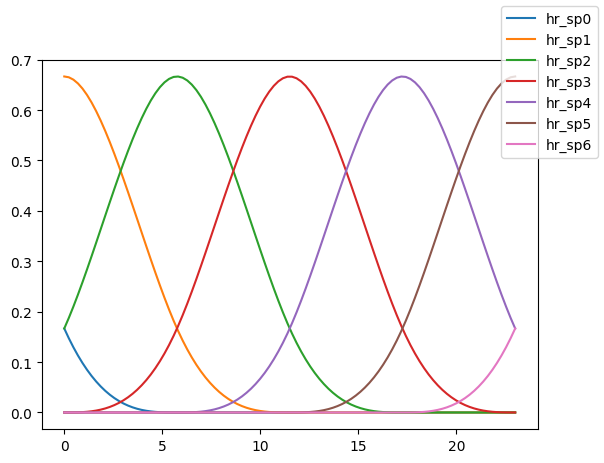

In [ ]:
## Look at the spline functions
## This shows which spline functions are constructed and then used
## to estimate non-linear relationships
hr_grid = np.linspace(train_x['hr'].min(), train_x['hr'].max(),100)
hr_sp_grid = pd.DataFrame(tf_hr.transform(hr_grid.reshape(-1,1)), columns = ['hr_sp'+str(i) for i in range(nk+2)])

fig, ax = plt.subplots(1,1)
for v in hr_sp_grid.columns:
  ax.plot(hr_grid, hr_sp_grid[v], label=v)
fig.legend()

In [ ]:
## Add these new variables (spline functions) to the data frames
ext_train_x = pd.concat([train_x.reset_index(drop=True), hr_sp_train, at_sp_train], axis=1, )

ext_test_x = pd.concat([test_x.reset_index(drop=True), hr_sp_test, at_sp_test], axis=1)

ext_predictors = ['workingday', 'hum', 'windspeed', 'season_2', 'season_3', 'season_4',
       'weathersit_2', 'weathersit_3', 'weathersit_4',] + ['hr_sp'+str(i) for i in range(nk+2)] + ['at_sp'+str(i) for i in range(nk+2)]


In [ ]:
ext_train_x.shape

(13903, 25)

In [ ]:
train_x.columns

Index(['hr', 'workingday', 'atemp', 'hum', 'windspeed', 'season_2', 'season_3',
       'season_4', 'weathersit_2', 'weathersit_3', 'weathersit_4'],
      dtype='object')

In [ ]:
ext_train_x.columns

Index(['hr', 'workingday', 'atemp', 'hum', 'windspeed', 'season_2', 'season_3',
       'season_4', 'weathersit_2', 'weathersit_3', 'weathersit_4', 'hr_sp0',
       'hr_sp1', 'hr_sp2', 'hr_sp3', 'hr_sp4', 'hr_sp5', 'hr_sp6', 'at_sp0',
       'at_sp1', 'at_sp2', 'at_sp3', 'at_sp4', 'at_sp5', 'at_sp6'],
      dtype='object')

In [ ]:
sklm_sp = LinearRegression()
sklm_sp.fit(ext_train_x[ext_predictors], train_y)

LinearRegression()

In [ ]:
train_yhat_sp = sklm_sp.predict(ext_train_x[ext_predictors])
test_yhat_sp = sklm_sp.predict(ext_test_x[ext_predictors])

In [ ]:
## Coefficients for our new model.
## Note that each spline basis function has a coefficient.
coefs = pd.Series(sklm_sp.coef_, index=ext_predictors)
coefs

workingday      -0.033414
hum             -0.466196
windspeed       -0.134971
season_2         0.272751
season_3         0.317343
season_4         0.464993
weathersit_2    -0.046550
weathersit_3    -0.538397
weathersit_4     0.391527
hr_sp0          23.604064
hr_sp1          -9.602592
hr_sp2          -1.602544
hr_sp3          -1.787177
hr_sp4          -1.169997
hr_sp5          -1.756746
hr_sp6          -7.685008
at_sp0          -1.752158
at_sp1          -0.440605
at_sp2           0.299769
at_sp3           0.918616
at_sp4           1.310141
at_sp5          -0.053432
at_sp6          -0.282332
dtype: float64

In [ ]:
## Calculate Metrics
print('MSE for test:', round(mean_squared_error(test_y, test_yhat_sp), 4))
print('MSE for training:', round(mean_squared_error(train_y, train_yhat_sp),4))
print('MAE for test:', round(mean_absolute_error(test_y, test_yhat_sp), 4))
print('MAE for training:', round(mean_absolute_error(train_y, train_yhat_sp),4))
print('r2 for test:', round(r2_score(test_y, test_yhat_sp), 4))
print('r2 for training:', round(r2_score(train_y, train_yhat_sp),4))

MSE for test: 0.5872
MSE for training: 0.5641
MAE for test: 0.5711
MAE for training: 0.5632
r2 for test: 0.7372
r2 for training: 0.7438


In [ ]:
## Look at the nonlinear tranformation we've learned
## Here, we're plotting the aggregate effect of the spline
## terms to see the nonlinear relationship in the model



hr_grid = np.linspace(train_x['hr'].min(), train_x['hr'].max(),100)
hr_sp_grid = pd.DataFrame(tf_hr.transform(hr_grid.reshape(-1,1)), columns = ['hr_sp'+str(i) for i in range(nk+2)])
nlt = np.zeros(hr_grid.shape)

for v in hr_sp_grid.columns:
  nlt += hr_sp_grid[v]*coefs[v]

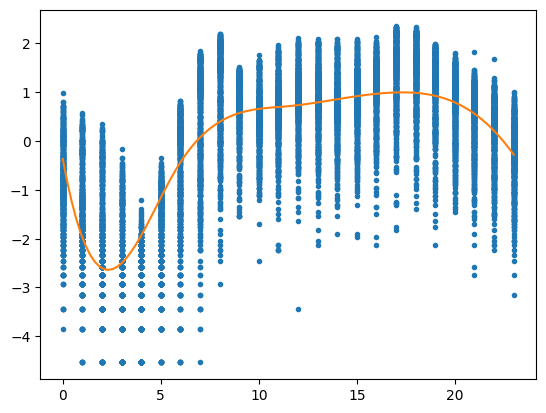

In [ ]:
## Plot the resulting spline transformation
## Note that this follows the relationship better
## than a single linear term could.
plt.plot(train_x['hr'],train_y-train_y.mean(),  '.')
plt.plot(hr_grid, nlt-nlt.mean())